## Hour and Month

We look at the frequency of bird strikes according to hour of the day (e.g. 4 AM) and month (e.g. January), and plot it using a heatmap.

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, let's get the strike data and store it as a DataFrame.

In [158]:
# Read in the strike data
strikes = pd.read_csv("strikes_2000_2019.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,77,86,96,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
# Make a smaller data frame to focus on the strike time and place
strike_times = strikes[['INDX_NR','INCIDENT_DATE ','STATE',
                        'AIRPORT_ID', 'OPERATOR_ID','SPECIES_ID',
                        'DAMAGE','COST_REPAIRS',
                        'INCIDENT_MONTH','INCIDENT_YEAR',
                        'TIME_OF_DAY','TIME',
                        'FAAREGION','ENROUTE','LOCATION',
                        'HEIGHT','SPEED','DISTANCE',
                        'PHASE_OF_FLIGHT',
                        'EFFECT_NONE', 'EFFECT_ABORTED', 
                        'EFFECT_PREC_LAND', 'EFFECT_ENG_SHUT', 
                        'EFFECT_OTH', 'EFFECT_OTHER',
                        'SKY', 'PRECIP_FOG', 'PRECIP_RAIN', 
                        'PRECIP_SNOW', 'PRECIP_NONE', 
                        'BIRDS_SEEN', 'BIRDS_STRUCK', 'SIZE', 
                        'WARNED', 'REMARKS', 'AOS',
                        'OTHER_COST', 'COST_REPAIRS_INFL_ADJ', 
                        'COST_OTHER_INFL_ADJ','COMMENT',
                        'INDICATED_DAMAGE']]

In [160]:
# In the TIME column in the original data set, 
# empty entries are denoted by the string '     '.
# Here we replace all strings of 5 spaces with NaN
# to make empty entries in the TIME column easier to identify.
strike_times = strike_times.replace('     ', np.nan)

In [161]:
# Convert the times in the 'TIME' column to datetime
# Unfortunately this assigns a date of 1900-01-01
strike_times['TIME'] = pd.to_datetime(strike_times['TIME'], 
                                      format= '%H:%M')

In [162]:
# Convert the 'INCIDENT_DATE ' column to datetime
strike_times['INCIDENT_DATE '] = pd.to_datetime(strike_times['INCIDENT_DATE '])

Let's make a train-test split, and then plot our training data using a heat map. The features we are interested in are the hour and month of each strike.

In [392]:
# Just look at strike month and hour
strike_mh = pd.DataFrame()
strike_mh['MONTH'] = pd.to_numeric(strike_times['INCIDENT_DATE '].dt.month)
strike_mh['HOUR'] = pd.to_numeric(strike_times['TIME'].dt.hour)

In [394]:
# We want to count how many strikes were reported for each (month, hour) pair.
# Note that many 'HOUR' values are missing for many strikes,
# and we're omitting those strikes here.
strike_mh_counts = strike_mh['HOUR'].groupby(strike_mh['MONTH']).value_counts()

In [395]:
# Reformat strike_mh data into a 2D numpy array
strike_mh_array = np.zeros((12,24))
for m in range(0,12):
    for h in range(0,24):
        strike_mh_array[m,h] = strike_mh_counts[m+1,h]

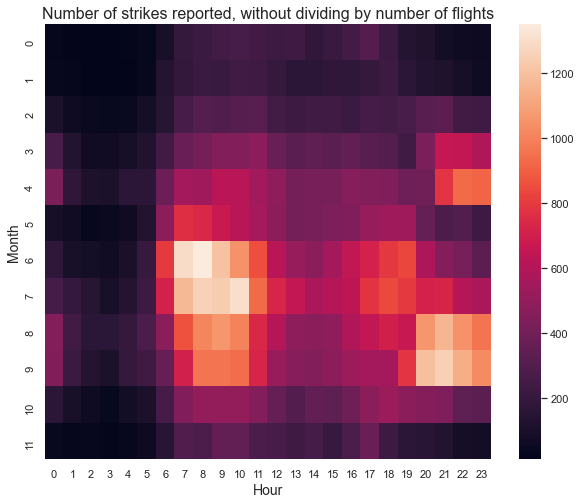

In [396]:
import seaborn as sns

plt.figure(figsize = (10,8))

sns.heatmap(strike_mh_array)

plt.xlabel('Hour', fontsize = 14)
plt.ylabel('Month', fontsize = 14)

plt.title('Number of strikes reported, without dividing by number of flights', fontsize=16)

plt.show()

The problem with the above plot is that we haven't accounted for the number of flights. To remedy this, we'll divide by the total number of flights scheduled to arrive during each (month, hour) pair.

In [310]:
# The approach is the phase of flight with the most bird strikes
# Therefore, we'll use scheduled arrivals as our estimate for number of flights
strike_times['PHASE_OF_FLIGHT'].value_counts()

Approach        54836
Landing Roll    22306
Take-off Run    21600
Climb           19228
En Route         3278
Descent          1634
Departure        1528
Local             660
Arrival           528
Taxi              416
Parked            109
Unknown            43
Name: PHASE_OF_FLIGHT, dtype: int64

In [397]:
# Load in the flight data for each year from 2000 through 2019
# Store it as a list called flights,
# where flights[i] = the data frame for the year 2000+i

flights = []

for year in range(0, 20):
    flight_df = pd.read_csv("flights_monthly_hourly/flights_monthly_hourly_{}.csv".format(str(2000+year)), 
                            skiprows = [0, 290],
                            thousands=',')
    # Convert the 'Date' column to datetime format
    flight_df['Date'] = pd.to_datetime(flight_df['Date'])
    flights.append(flight_df)

In [398]:
# Make an array of the total number of flights scheduled 
# to arrive during each (month, hour) pair

flights_mh_array = np.zeros((12,24))
for m in range(0,12):
    for h in range(0,24):
        flights_mh_array[m,h] = sum([flights[y].loc[(flights[y]['Date'].dt.month == m+1) &\
                                                    (flights[y]['Hour'] == h)]['ScheduledArrivals']\
                                                    for y in range(0,20)])

In [399]:
# Make an array of strikes per flight for each (month, hour) pair

strikes_per_flight = np.zeros((12,24))

for m in range(0,12):
    for h in range(0,24):
        strikes_per_flight[m,h] = strike_mh_array[m,h]/flights_mh_array[m,h]

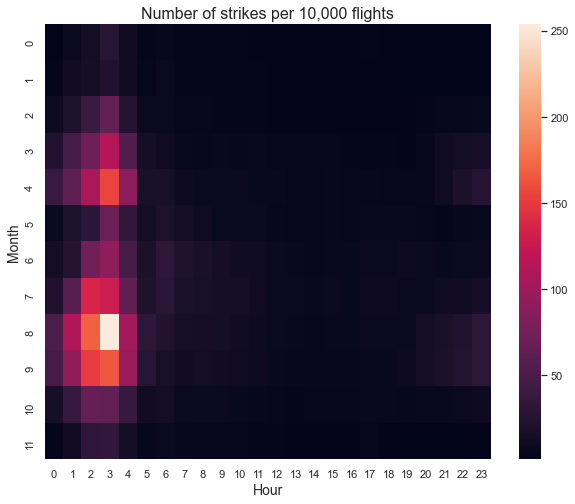

In [401]:
# Plot strikes per flight as a heatmap

strikes_per_flight_scaled = np.array(strikes_per_flight)*10000

plt.figure(figsize = (10,8))

sns.heatmap(strikes_per_flight_scaled)

plt.xlabel('Hour', fontsize = 14)
plt.ylabel('Month', fontsize = 14)

plt.title('Number of strikes per 10,000 flights', fontsize=16)

plt.show()